In [1]:
from my import source as my
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 使用乳腺癌数据集演示二分类任务,这是个小型数据集，使用起来更快
data = load_breast_cancer()
# 特征数据 DataFrame
df_features = my.pd.DataFrame(data.data, columns=data.feature_names)

# 目标标签 DataFrame
df_labels = my.pd.DataFrame(data.target, columns=["target"])

# 可选：合并特征数据和目标标签到一个 DataFrame
df = my.pd.concat([df_features, df_labels], axis=1)
viewer = my.ViewDataframe(df)
viewer.display_info()


--- 数据维度 ---
维度: 569 行 x 31 列

--- 特征类型 ---
                            数据类型
mean radius              float64
mean texture             float64
mean perimeter           float64
mean area                float64
mean smoothness          float64
mean compactness         float64
mean concavity           float64
mean concave points      float64
mean symmetry            float64
mean fractal dimension   float64
radius error             float64
texture error            float64
perimeter error          float64
area error               float64
smoothness error         float64
compactness error        float64
concavity error          float64
concave points error     float64
symmetry error           float64
fractal dimension error  float64
worst radius             float64
worst texture            float64
worst perimeter          float64
worst area               float64
worst smoothness         float64
worst compactness        float64
worst concavity          float64
worst concave points     float6

In [3]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_trainval, X_test, y_trainval, y_test = my.cut_data(X, y, stratified=True)
# 使用my包搭建支持向量机时需要增加这个参数
base_line = SVC(probability=True)
my.train_classification_baseline(base_line, X_trainval, y_trainval, stratified=True, is_print=True, eval_metrics=[my.accuracy_score, my.precision_score, my.recall_score])

运行时间0.2504427433013916秒
模型结果:
        F1_score   AUC  accuracy_score  precision_score  recall_score
train     0.938 0.974           0.919            0.896         0.986
val       0.936 0.969           0.914            0.894         0.984


In [ ]:
'''
这是一段错误的调参代码，如果你在使用时遇到了像这段代码一样的问题：‘程序可以正常运行但是卡在某一步无法向下’。这可能是optuna陷入了局部最优解，你需要调整你的参数范围

当然这种调参并非没有益处，观察日志可以发现最优值停在了0.9143589743589745，这只比我们baseline的十折交叉验证的验证集得分略高了一点点。并且回到这个例子本身，支持向量机的参数比较简单，baseline也没有过拟合的现象，继续往下调参的意义不大
'''
# 尝试调参
# params = {'kernel': ['categorical', 'rbf', 'linear', 'sigmoid'], 'gamma': ['categorical', 'scale', 'auto'], 'probability':True}
# optuna_frame = my.OptunaForGeneralML(X_trainval, y_trainval, task_type='classification', params=params, ml_method='sklearn.svm.SVC', scoring=my.accuracy_score.__name__)
# best_params, best_value = optuna_frame.optimize(n_trials=50, eval_metrics=[my.accuracy_score])
# print(best_params, best_value)

[I 2024-04-22 15:34:29,268] A new study created in memory with name: no-name-5d3975f3-2588-4d7b-ba4c-b9ade7341f53
[I 2024-04-22 15:34:30,752] Trial 0 finished with value: 0.6282051282051283 and parameters: {'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.6282051282051283.
[I 2024-04-22 15:34:30,808] Trial 9 finished with value: 0.6282051282051283 and parameters: {'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.6282051282051283.
[I 2024-04-22 15:34:30,823] Trial 8 finished with value: 0.6282051282051283 and parameters: {'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.6282051282051283.
[I 2024-04-22 15:34:30,862] Trial 3 finished with value: 0.6282051282051283 and parameters: {'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.6282051282051283.
[I 2024-04-22 15:34:30,906] Trial 10 finished with value: 0.9143589743589745 and parameters: {'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 10 with value: 0.91435

In [4]:
# 采用原始参数
params = {'probability': True}
best_model = my.BuildBestModel(X_trainval, y_trainval, X_test, y_test, model_params=params, task_type='classification', ml_method='sklearn.svm.SVC', eval_metrics=[my.accuracy_score, my.precision_score, my.recall_score], probably_params={'average': 'micro'})
best_model.train()

运行时间0.25118064880371094秒
模型结果:
        F1_score   AUC  accuracy_score  precision_score  recall_score
train     0.938 0.974           0.919            0.896         0.986
val       0.936 0.969           0.914            0.894         0.984


In [5]:
effect = best_model.evaluate()
print(effect)

{'auc': 0.9690420560747663, 'f1_score': 0.9285714285714286, 'accuracy_score': 0.9064327485380117, 'precision_score': 0.9064327485380117, 'recall_score': 0.9064327485380117}


In [4]:
# 尝试一下LightGBM
# 这个数据集相当简单，训练集准确率直接可以达到百分之百，并且出现了警告No further splits with positive gain, best gain: -inf
# 说明模型不会带来任何的正增益了，这个模型已经训练到头了
base_line_lgb = my.lgb.LGBMClassifier(random_state=123, n_jobs=-1)
my.train_classification_baseline(base_line_lgb, X_trainval, y_trainval, stratified=True, is_print=True, eval_metrics=[my.accuracy_score, my.precision_score, my.recall_score])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225, number of negative: 133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3582
[LightGBM] [Info] Number of data points in the train set: 358, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628492 -> initscore=0.525751
[LightGBM] [Info] Start training from score 0.525751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [5]:
# 这个模型可以继续往下调参，但是效果反而会下降
# 这里仅作为二分类任务的演示，不具备实际建模意义
optuna_frame_lgb = my.OptunaForLGB(X_trainval, y_trainval, task_type='binary', stopping_rounds=30, eval_metric=my.accuracy_score)
best_params_lgb, best_value_lgb = optuna_frame_lgb.optimize_lgb(n_trials=30)
print(best_params_lgb, best_value_lgb)

[I 2024-04-27 22:14:22,816] A new study created in memory with name: no-name-e94afc3e-789a-44ef-8bda-c3a64dcc3611


Training until validation scores don't improve for 30 roundsTraining until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.942667
Training until validation scores don't improve for 30 rounds
Early stopping, best i

In [6]:
# 不出意外的效果下降了
best_models_lgb = my.lgb.LGBMClassifier(**best_params_lgb)
my.train_classification_baseline(best_models_lgb, X_trainval, y_trainval, stratified=True, is_print=True, eval_metrics=[my.accuracy_score, my.precision_score, my.recall_score])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225, number of negative: 133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3582
[LightGBM] [Info] Number of data points in the train set: 358, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628492 -> initscore=0.525751
[LightGBM] [Info] Start training from score 0.525751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

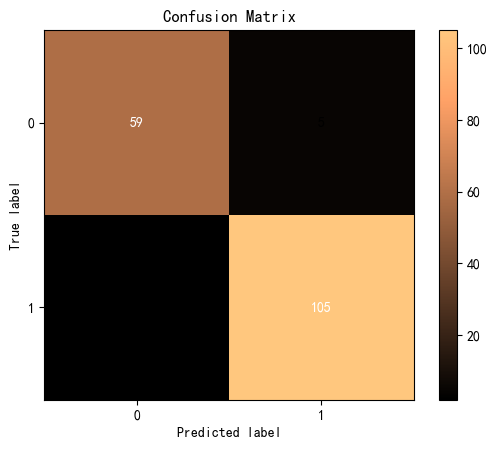

In [8]:
pred = base_line_lgb.predict(X_test)
pred_proba = base_line_lgb.predict_proba(X_test)
ml_plot = my.PlotForML(y_test, pred, pred_proba)
ml_plot.plot_confusion_matrix(cmap='copper')

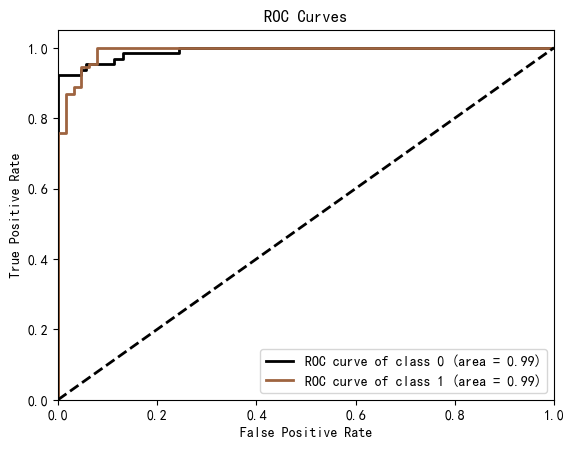

In [9]:
ml_plot.plot_roc(cmap='copper')

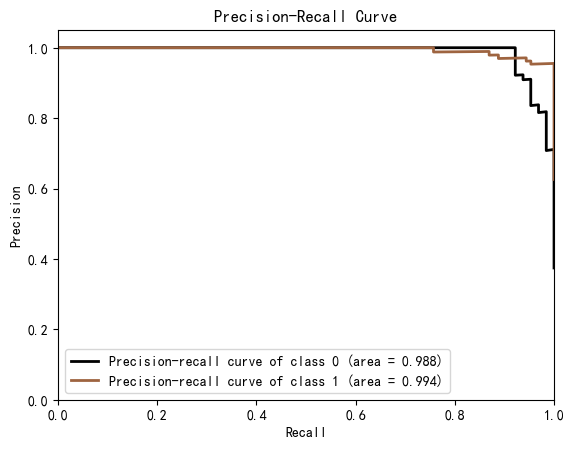

In [10]:
ml_plot.plot_precision_recall(cmap='copper')

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 22, number of negative: 13
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 35, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training from score 0.526093
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves th

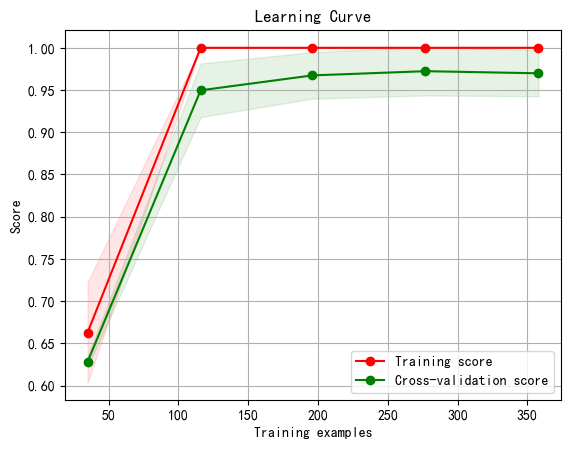

In [11]:
ml_plot.learning_curve(base_line_lgb, X_trainval, y_trainval, scoring='accuracy')